In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact, interactive, fixed, interact_manual
import calendar

sns.set()

# Make charts a bit bolder
sns.set_context("talk")


In [92]:
%matplotlib inline

plt.style.use('fivethirtyeight')

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)

# Define a common date format
DATE_FORMAT = "%d.%m.%Y" 

# Define a common qualitative color palette (origin: https://seaborn.pydata.org/tutorial/color_palettes.html)
QUALITATIVE_PALETTE = "deep"
SEQUENTIAL_PALETTE = "BuGn_d"

sns.set(rc={"figure.figsize": (12, 6)})

In [5]:
data = pd.read_csv('globalterrorismdb.csv', encoding='latin1', index_col='eventid')



/Users/mihailojoksimovic/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (4,6,31,33,53,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [6]:
data.rename(columns={'iyear':'Year','imonth':'Month','iday':'Day','country_txt':'Country','region_txt':'Region','attacktype1_txt':'AttackType','target1':'Target','nkill':'Killed','nwound':'Wounded','summary':'Summary','gname':'Group','targtype1_txt':'Target_type','weaptype1_txt':'Weapon_type','motive':'Motive','success':'Success'},inplace=True)

In [7]:
data = data[['Year','Month','Day','Country','Region','city','latitude','longitude','AttackType','Killed','Wounded','Target','Summary','Group','Target_type','Weapon_type','Motive','Success']]

In [8]:
data.head()

,Year,Month,Day,Country,Region,city,latitude,longitude,AttackType,Killed,Wounded,Target,Summary,Group,Target_type,Weapon_type,Motive,Success
eventid,,,,,,,,,,,,,,,,,,
197000000001,1970,7,2,Dominican Republic,Central America & Caribbean,Santo Domingo,18.456792,-69.951164,Assassination,1.0,0.0,Julio Guzman,NaN,MANO-D,Private Citizens & Property,Unknown,NaN,1
197000000002,1970,0,0,Mexico,North America,Mexico city,19.432608,-99.133207,Hostage Taking (Kidnapping),0.0,0.0,"Nadine Chaval, daughter",NaN,23rd of September Communist League,Government (Diplomatic),Unknown,NaN,1
197001000001,1970,1,0,Philippines,Southeast Asia,Unknown,15.478598,120.599741,Assassination,1.0,0.0,Employee,NaN,Unknown,Journalists & Media,Unknown,NaN,1
197001000002,1970,1,0,Greece,Western Europe,Athens,37.983773,23.728157,Bombing/Explosion,NaN,NaN,U.S. Embassy,NaN,Unknown,Government (Diplomatic),Explosives/Bombs/Dynamite,NaN,1
197001000003,1970,1,0,Japan,East Asia,Fukouka,33.580412,130.396361,Facility/Infrastructure Attack,NaN,NaN,U.S. Consulate,NaN,Unknown,Government (Diplomatic),Incendiary,NaN,1


# Cleanup

## Augment date & time for columns that are missing it

In [9]:
no_month = data['Month'] == 0
no_day = data['Day'] == 0

# Augment day & month for rows where this info is missing ..

data['is_daymonth_augmented'] = False

# Let's just take all rows without Month & Date & assign them to January 1st of the year when they happened
data.loc[no_month | no_day, 'is_daymonth_augmented'] = True
data.loc[no_month, 'Month'] = 1
data.loc[no_day, 'Day'] = 1

## Introduce Full Date time

In [10]:
# Create a FullDateTime column out of year, month and date
data.insert(0, 'FullDateTime', pd.to_datetime(dict(year=data.Year, month=data.Month, day=data.Day)))

# Introduce month names as well
data['Month_Name'] = data['Month'].map(lambda x: calendar.month_abbr[x])

## Column types conversion

In [11]:
data['Success'] = data['Success'].astype(bool)

## Data wrangle

In [12]:
# Introduce shortnames for Terrorist groups, as usually the names are waaay too long
data['Group_Shortname'] = data['Group'].map(lambda x: x[:20] + "...")

## Fill in mean longitude and latitude where it's missing

In [34]:
print("Number of countries without longitude and latitiude: " + str(data[data['longitude'].isnull() & data['latitude'].isnull()].shape[0]))

Number of countries without longitude and latitiude: 4606


In [38]:
# Find mean long and lat based on country

data_with_long_and_lat = data[~data['longitude'].isnull() & ~data['latitude'].isnull()]

country_mean_long_lat = data_with_long_and_lat.groupby('Country')[['longitude', 'latitude']].mean()

country_mean_long_lat.head(5)

,longitude,latitude
Country,,
Afghanistan,67.163658,33.827390
Albania,19.843097,41.064749
Algeria,3.396180,36.222000
Angola,14.968410,-10.121350
Antigua and Barbuda,-61.845557,17.117528


In [40]:
# Now fill in the blanks ;-)

for i, row in data[data['latitude'].isnull()][['Country', 'city']].iterrows():
    country = row['Country']
    
    if (country in country_mean_long_lat.index):    
        # Find median long and lat
        long = country_mean_long_lat.loc[country]['longitude']
        lat = country_mean_long_lat.loc[country]['latitude']
        
        data.set_value(i, 'latitude', lat)
        data.set_value(i, 'longitude', long)

/Users/mihailojoksimovic/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()
/Users/mihailojoksimovic/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if sys.path[0] == '':


In [41]:
print("Number of countries without longitude and latitiude: " + str(data[data['longitude'].isnull() & data['latitude'].isnull()].shape[0]))

Number of countries without longitude and latitiude: 1


In [47]:
data.fillna(value={'longitude' : 0, 'latitude': 0}, inplace=True)

print("Number of countries without longitude and latitiude: " + str(data[data['longitude'].isnull() & data['latitude'].isnull()].shape[0]))

Number of countries without longitude and latitiude: 0


# European Data

In [154]:
europe = data[data.Region.str.contains('Europe')]

In [155]:
europeYearlyMean = europe['Year'].value_counts().mean()
europeYearlyMedian = europe['Year'].value_counts().median()

In [156]:
print("Total number of attacks in Europe since 1970: " + str(europe.shape[0]))

Total number of attacks in Europe since 1970: 21338


In [157]:
europeSorted = europe.sort_values(by='FullDateTime')

# Look for earliest attack where date was not augmented
earliestAttack = europeSorted[europeSorted['is_daymonth_augmented'] == False].iloc[0]

# Look for latest attack where date was not augmented
latestAttack = europeSorted[europeSorted['is_daymonth_augmented'] == False].iloc[-1]

In [158]:
def print_newsline(obj):
    """Prints a newsline given the Series object
    """
    
    return (obj.AttackType + " that happened on "+
      obj.FullDateTime.strftime(DATE_FORMAT) +
      " in " + obj['city'] + ", " + obj['Country'] + ". " +
            "Target was " + obj.Target + " and the weapon that was used was " +
            obj.Weapon_type + "."
    )
    
print("Earliest recorded attack in Europe was " + print_newsline(earliestAttack))
print()
print("Latest recorded attack in Europe was " + print_newsline(latestAttack))



Earliest recorded attack in Europe was Hijacking that happened on 08.01.1970 in Rome, Italy. Target was Flight 802 Boeing 707 and the weapon that was used was Firearms.

Latest recorded attack in Europe was Bombing/Explosion that happened on 30.12.2016 in Belfast, United Kingdom. Target was Unknown and the weapon that was used was Explosives/Bombs/Dynamite.


## Trend

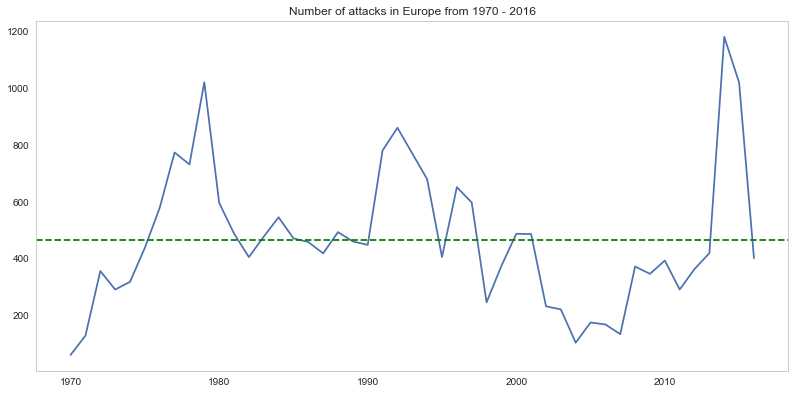

In [159]:
plotData = europe['Year'].value_counts().sort_index()

with sns.axes_style("whitegrid"):
    g = plotData.plot()
    g.grid(False)
    plt.axhline(y=europeYearlyMean, color='g', linestyle='--')
    plt.title("Number of attacks in Europe from 1970 - 2016")


Text(0.5,1,'Top 10 countries with highest number of attacks')

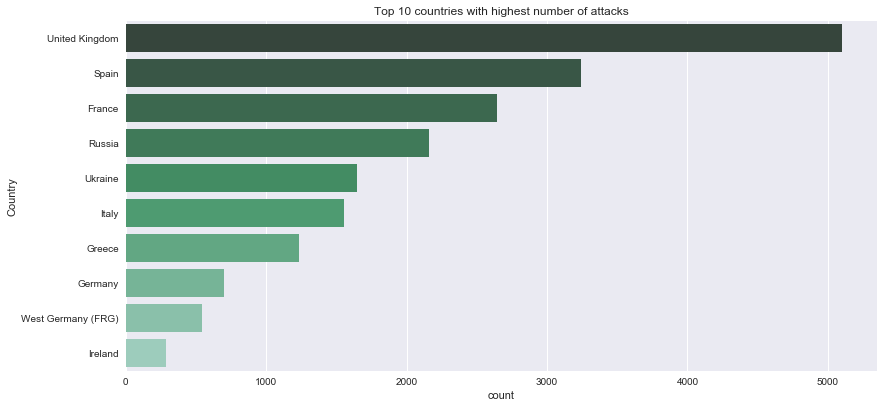

In [160]:
sns.countplot(y='Country', data=europe, order=europe['Country'].value_counts().index[:10], palette="BuGn_d")
plt.title("Top 10 countries with highest number of attacks")

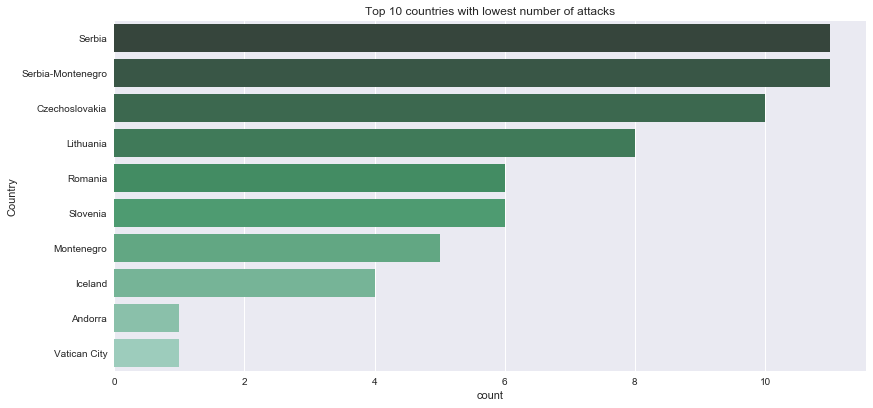

In [161]:
# Countries with least number of attacks
sns.countplot(y='Country', data=europe, order=europe['Country'].value_counts().index[-10:], palette="BuGn_d")
plt.title("Top 10 countries with lowest number of attacks");

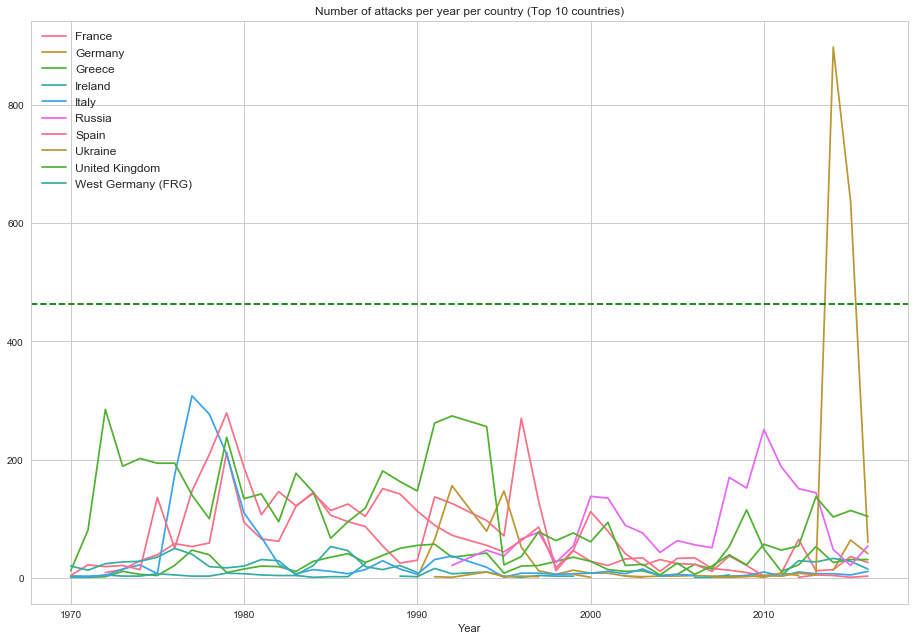

In [162]:
topTenCountries = europe['Country'].value_counts()[:10]
topTenCountriesDataframe = europe[europe['Country'].isin(topTenCountries.index)]
with sns.axes_style("whitegrid"):
    topTenCountriesDataframe.groupby(['Year','Country'])['Country'].count().sort_values().unstack().plot(figsize=(14, 10), color=sns.color_palette("husl"))
    plt.legend(fontsize="medium")
    plt.title("Number of attacks per year per country (Top 10 countries)")
    plt.axhline(y=europeYearlyMean, color='g', linestyle='--')

## Top 10 countries in last 10 years, grouped by year

In [163]:
lastTenYears = europe[europe.FullDateTime.dt.year >= 2008]

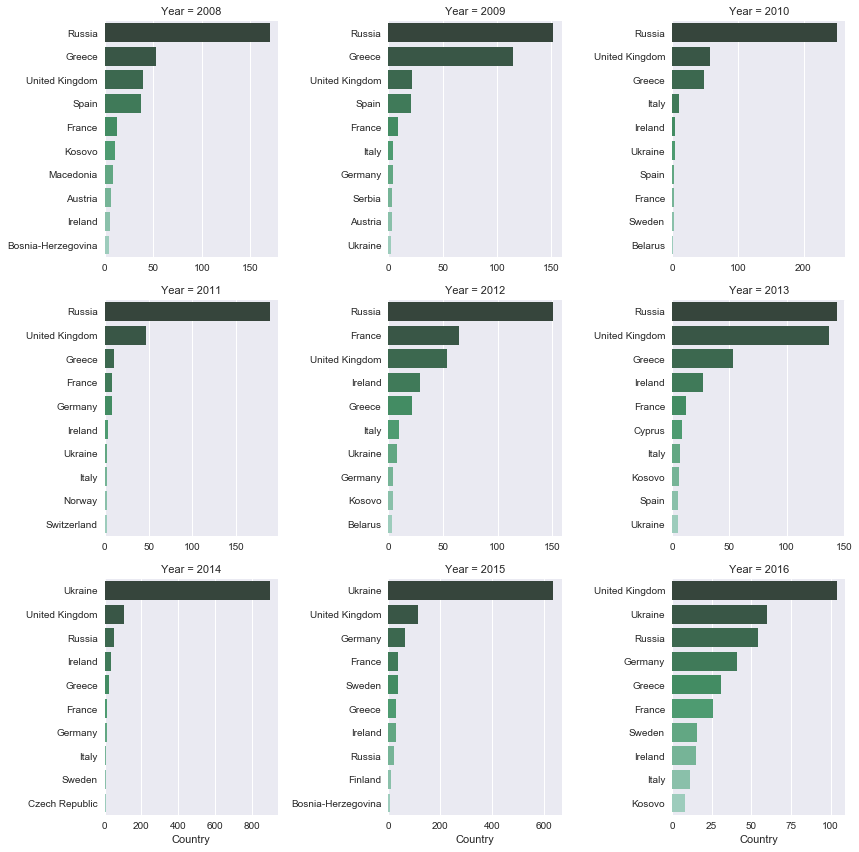

In [164]:
# Define a custom mapping function so that we can plot only top 10 countries
def countplot(data, **kwargs):
    sns.countplot(y=data, order=data.value_counts().index[:10], palette="BuGn_d")

grid = sns.FacetGrid(lastTenYears, col='Year', col_wrap=3, size=4, aspect=1, sharey=False, sharex=False)
grid.map(countplot, "Country")

## Number of attacks on monthly basis

Checking if there is any relation between a month and number of attacks (i.e. if warmer months are more prone to attacks)

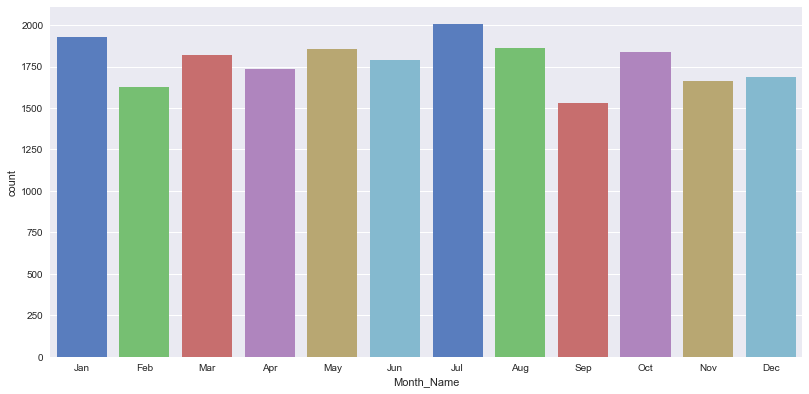

In [165]:
ax = sns.countplot(x='Month_Name', data=europe, palette='muted')

There doesn't seem to be any trend here ... Let's see if there is a trend if we group by year?

/Users/mihailojoksimovic/miniconda3/lib/python3.6/site-packages/seaborn/axisgrid.py:703: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


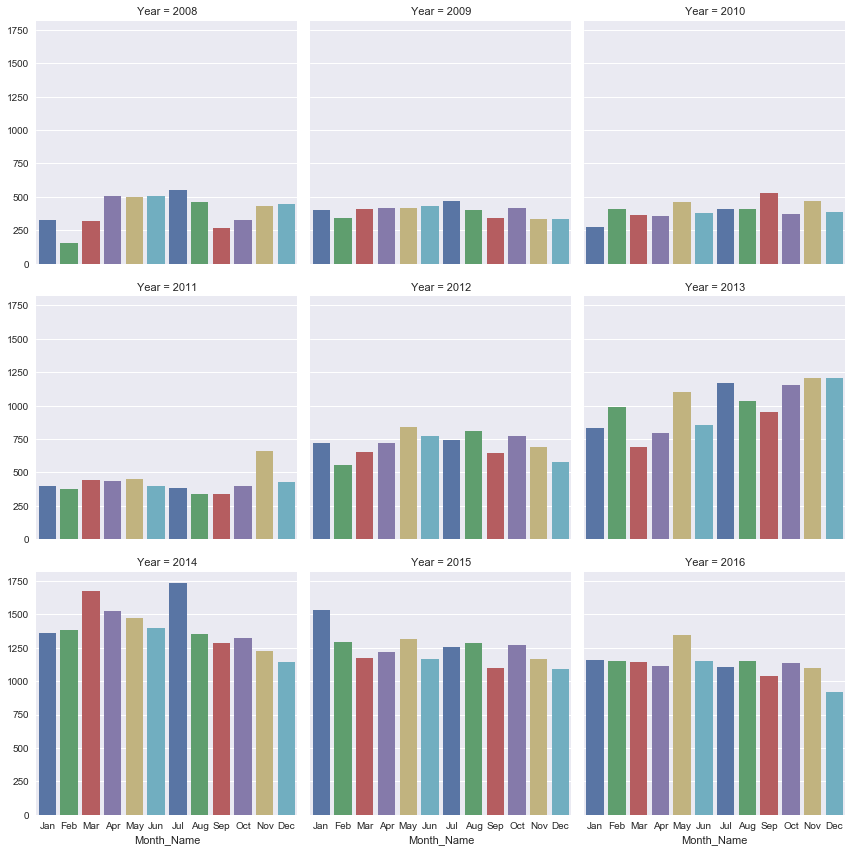

In [166]:
g = sns.FacetGrid(data[data['Year'] >= 2008], col='Year', col_wrap=3, size=4)
g.map(sns.countplot, 'Month_Name', palette=sns.color_palette())

There doesn't seem to be anything interesting there ... Let's try plotting the regional data now

## Regional data

In [167]:
europe['Region'].value_counts()

Western Europe    16307
Eastern Europe     5031
Name: Region, dtype: int64

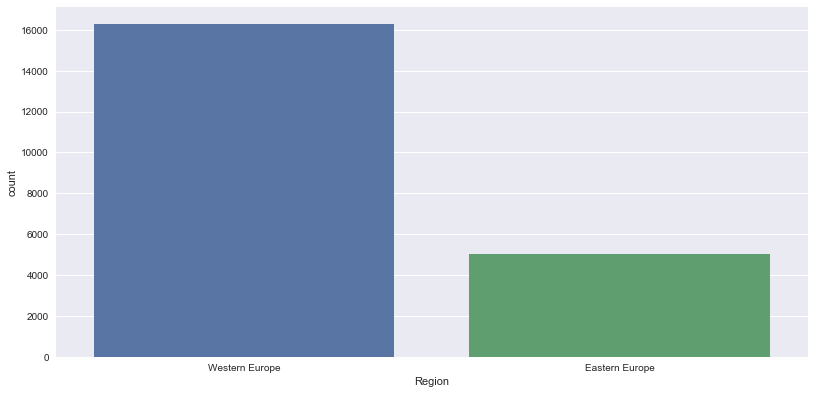

In [168]:
sns.countplot(europe['Region'])

That gives an interesting clue ... So number of attacks in Western Europe is way higher than in Eastern europe. Let's explore that further.

Let's start with drawing a trend and see if and how has this changed over time.

In [169]:
europeGroupedByRegion = europe.groupby(['Year', 'Region'])['Region'].count().unstack()

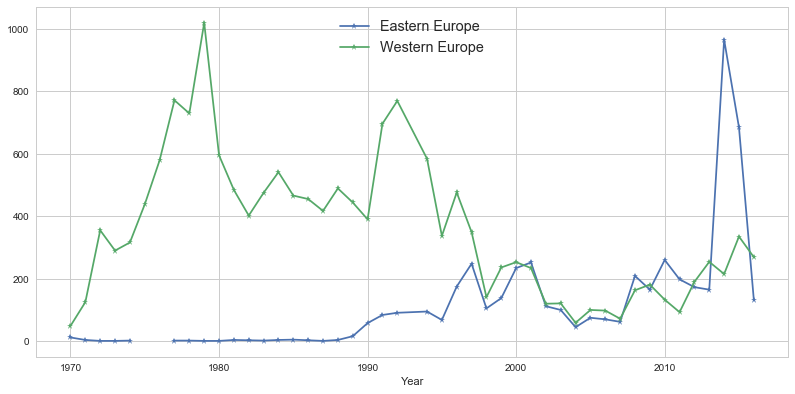

In [170]:
with sns.axes_style("whitegrid"):
    europeGroupedByRegion.plot(marker='*')
    plt.legend(fontsize="large")

So it seems that around 2016 or so something serious has happened, according to the spike. Let's see when/were that spike happened

In [171]:
europe[(europe['Region'] == 'Eastern Europe') & (europe['Year'] > 2010)].groupby('Year')['Year'].count()

Year
2011    198
2012    173
2013    165
2014    965
2015    684
2016    132
Name: Year, dtype: int64

So seems like 2014 and 2015th were interesting. Let's plot the data in separate figures and try drawing the trend line

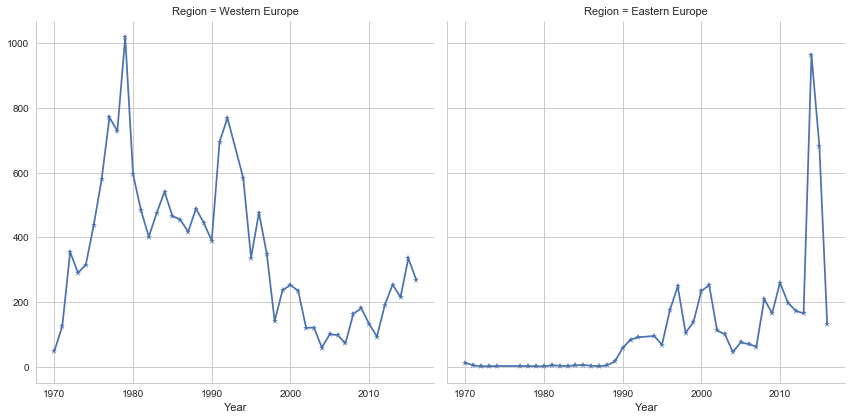

In [172]:
def countplot(x, **kwargs):
    x.value_counts().sort_index().plot(marker='*', **kwargs)

with sns.axes_style("whitegrid"):
    g = sns.FacetGrid(europe, col='Region', size=6)
    g.map(countplot, 'Year')

In [173]:
def countplot(x, **kwargs):
    x.value_counts().sort_index().plot(**kwargs)


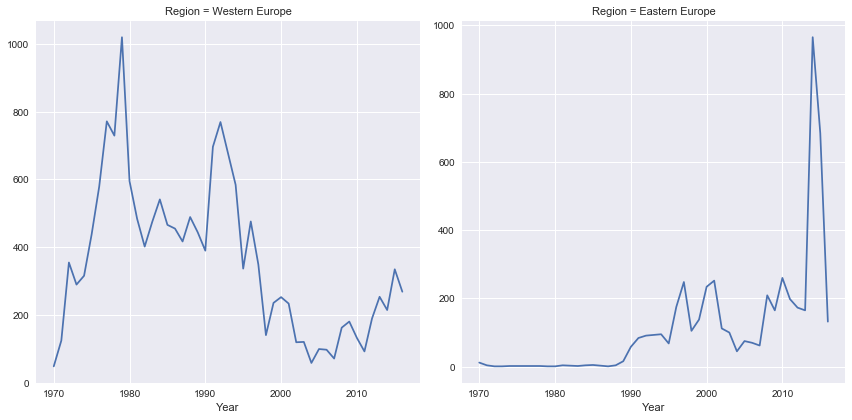

In [174]:
g = sns.FacetGrid(europe, col='Region', sharex=False, sharey=False, size=6)
g.map(countplot, 'Year')

Let's see the preferred method of attack

Text(0.5,1,'Preferred method of attack')

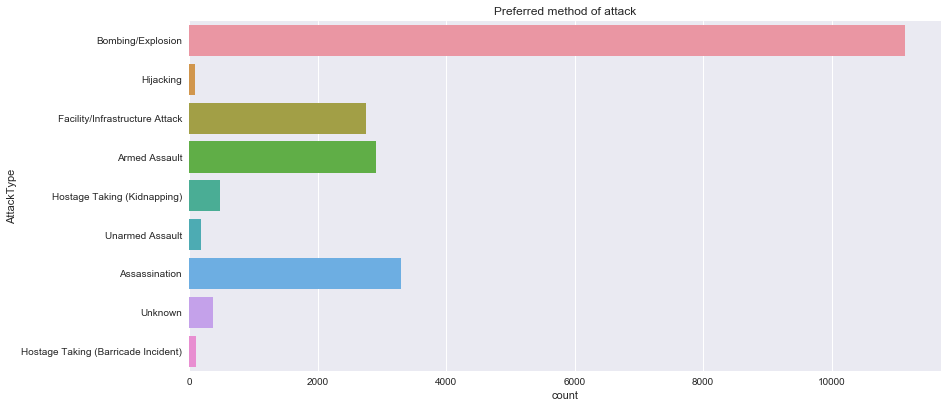

In [175]:
sns.countplot(y='AttackType', data=europe)
plt.title("Preferred method of attack")

Is there any difference based on the Region?

Text(0.5,8.96,'Count')

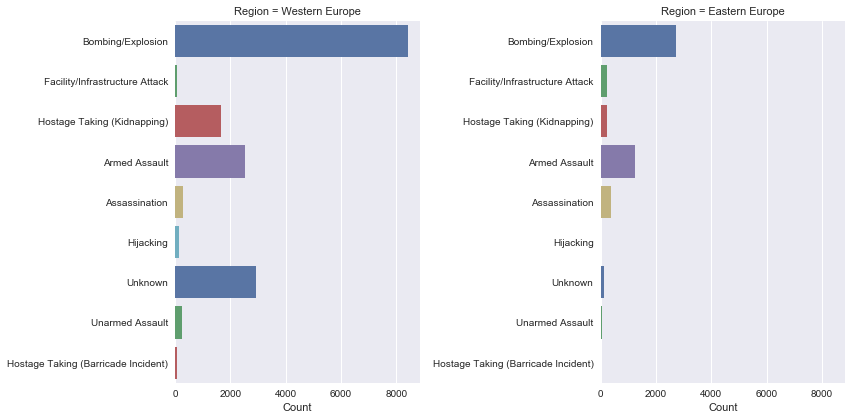

In [176]:
def countplot(y, **kwargs):
    ax = sns.countplot(y=y, **kwargs, palette='deep')

g = sns.FacetGrid(europe, col='Region', size=6)
g.map(countplot, 'AttackType')

g.axes[0,0].set_xlabel("Count")
g.axes[0,1].set_xlabel("Count")

Let's plot the successfullnes of attacks as a hue

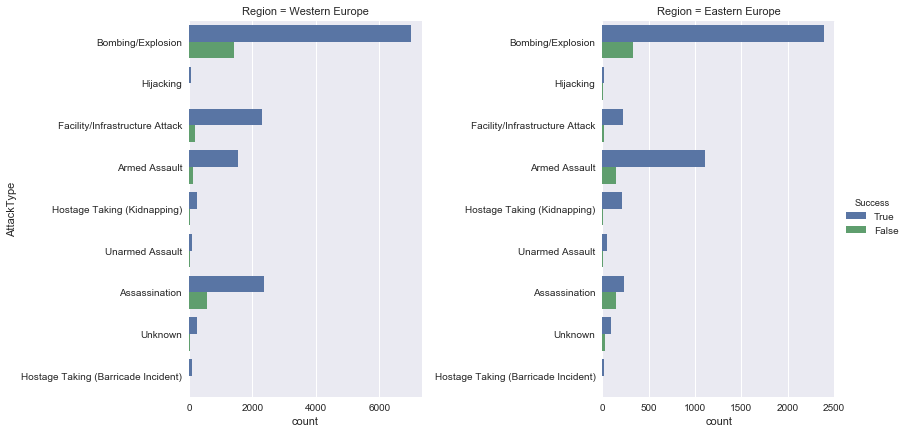

In [177]:
g = sns.factorplot(y='AttackType', hue='Success', col='Region', data=europe, kind='count', sharex=False, size=6, hue_order=[True, False], palette=QUALITATIVE_PALETTE)

Let's see which countries are most affected, grouped by region obviously

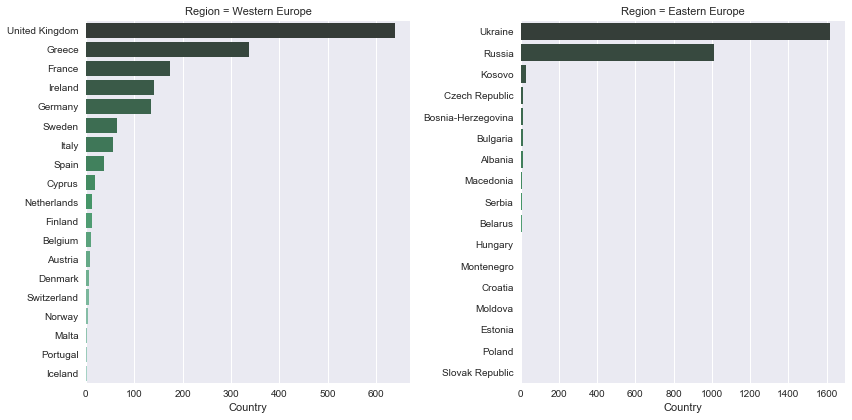

In [178]:
def countplot(y, **kwargs):
    ax = sns.countplot(y=y, palette=SEQUENTIAL_PALETTE, order=y.value_counts().index, **kwargs)

g = sns.FacetGrid(data=europe[europe['Year'] > 2008], col='Region', size=6, sharex=False, sharey=False, col_order=['Western Europe', 'Eastern Europe'])
g.map(countplot, 'Country')

Was there any change over the years?

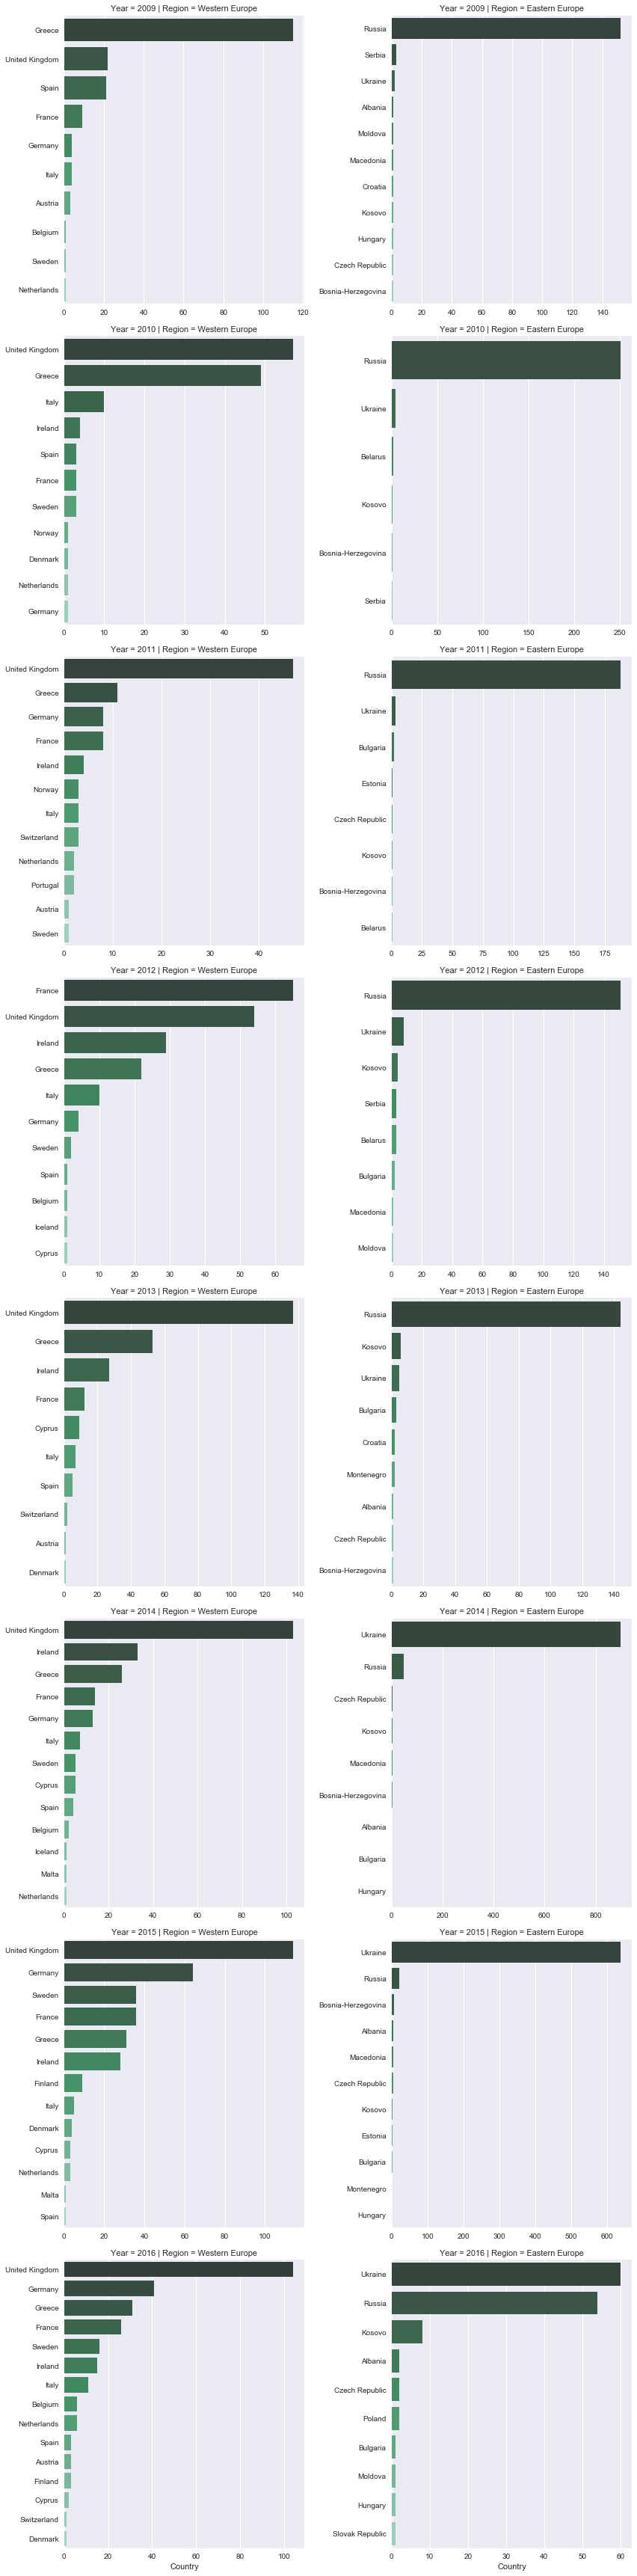

In [179]:
g = sns.FacetGrid(data=europe[europe['Year'] > 2008], col='Region', row='Year', size=6, sharex=False, sharey=False, col_order=['Western Europe', 'Eastern Europe'])
g.map(countplot, 'Country')

# Terrorist Groups

In [195]:
topGroups = europe[europe['Group'] != 'Unknown']['Group'].value_counts()[:10]
topGroupsDataFrame = europe[europe['Group'].isin(topGroups.index)]

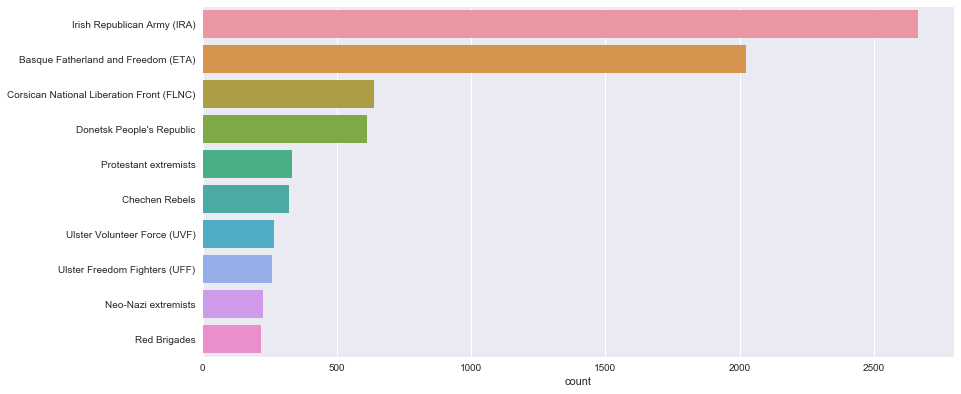

In [196]:
sns.countplot(y='Group', data=topGroupsDataFrame, order=topGroupsDataFrame['Group'].value_counts().index)
plt.ylabel("");

Let's do a comparison by region. NOTE: Won't be using Facetgrids due to names being super-long

In [192]:
group_is_known = europe['Group'] != 'Unknown' 

top10EasternEurope = europe[(europe['Region'] == 'Eastern Europe') & group_is_known]
top10WesternEurope = europe[(europe['Region'] == 'Western Europe') & group_is_known]

Text(0.5,1,'Top 10 Terrorist groups in Eastern Europe')

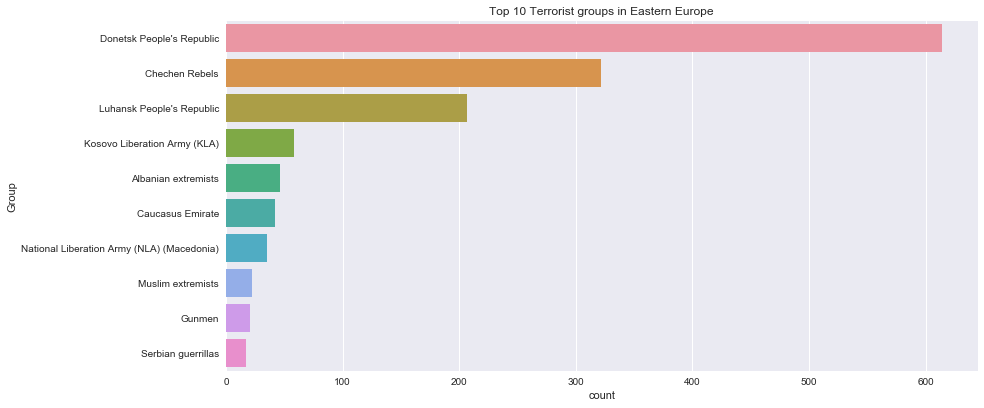

In [193]:
sns.countplot(y='Group', data=top10EasternEurope, order=top10EasternEurope['Group'].value_counts().index[:10])
plt.title("Top 10 Terrorist groups in Eastern Europe")

Text(0.5,1,'Top 10 Terrorist groups in Western Europe')

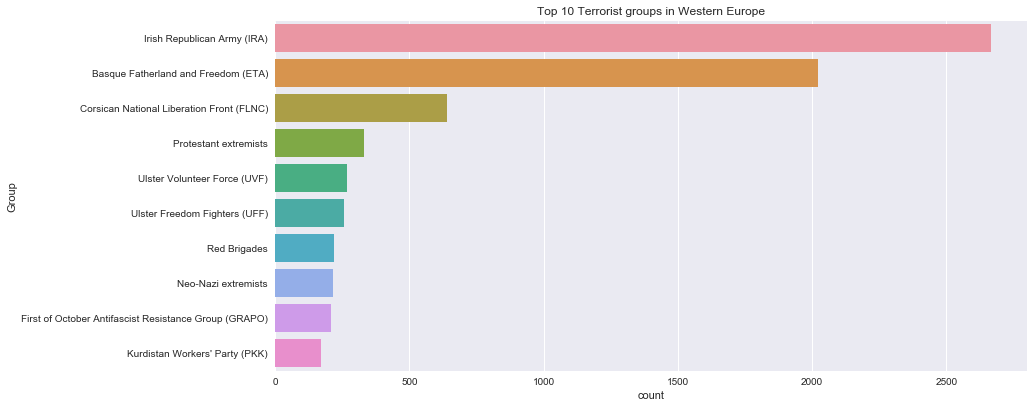

In [194]:
sns.countplot(y='Group', data=top10WesternEurope, order=top10WesternEurope['Group'].value_counts().index[:10])
plt.title("Top 10 Terrorist groups in Western Europe")

# Prediction

I want to predict success (1 or 0) based on the input features. For sake of ease, I'll just reload the dataset ;-)

In [220]:
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

In [200]:
data = pd.read_csv('globalterrorismdb.csv', encoding='latin1', index_col='eventid')

/Users/mihailojoksimovic/miniconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (4,6,31,33,53,61,62,63,76,79,90,92,94,96,114,115,121) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [201]:
# Leave only terrorist attacks
data = data[(data.crit1 == 1) & (data.crit2 == 1) & (data.crit3 == 1) & (data.doubtterr == 0)]

In [202]:
# Fill in missing longitudes and latitudes
# Now fill in the blanks ;-)

for i, row in data[data['specificity'] == 5.0][['country_txt', 'city']].iterrows():
    country = row['country_txt']

    if (country in country_mean_long_lat.index):    
        # Find median long and lat
        long = country_mean_long_lat.loc[country]['longitude']
        lat = country_mean_long_lat.loc[country]['latitude']

        data.at[i, 'latitude'] = lat
        data.at[i, 'longitude'] = long
        
# Augment number of casualties and introduce has_casualties (which we'll use for prediction)
data['ncasualties'] = data['nkill'] + data['nwound'] 
data['has_casualties'] = data['ncasualties'].apply(lambda x: 1 if x > 0 else 0)

# Replace unknown situations with 0 ...
data.loc[data['ishostkid'] == -9, 'ishostkid'] = 0

# Replace unknown situations with 0 ...
data.loc[data['ransom'] == -9, 'ransom'] = 0

# Replace unknown situations with 0 ...
data.loc[data['INT_LOG'] == -9, 'INT_LOG'] = 0

In [203]:
lb = LabelEncoder()

data['country_txt_encoded'] = lb.fit_transform(data['country_txt'])
data['region_txt_encoded'] = lb.fit_transform(data['country_txt'])

In [204]:
data.head(3)

,iyear,imonth,iday,approxdate,extended,resolution,country,country_txt,region,region_txt,provstate,city,latitude,longitude,specificity,vicinity,location,summary,crit1,crit2,crit3,doubtterr,alternative,alternative_txt,multiple,success,suicide,attacktype1,attacktype1_txt,attacktype2,attacktype2_txt,attacktype3,attacktype3_txt,targtype1,targtype1_txt,targsubtype1,targsubtype1_txt,corp1,target1,natlty1,natlty1_txt,targtype2,targtype2_txt,targsubtype2,targsubtype2_txt,corp2,target2,natlty2,natlty2_txt,targtype3,targtype3_txt,targsubtype3,targsubtype3_txt,corp3,target3,natlty3,natlty3_txt,gname,gsubname,gname2,gsubname2,gname3,gsubname3,motive,guncertain1,guncertain2,guncertain3,individual,nperps,nperpcap,claimed,claimmode,claimmode_txt,claim2,claimmode2,claimmode2_txt,claim3,claimmode3,claimmode3_txt,compclaim,weaptype1,weaptype1_txt,weapsubtype1,weapsubtype1_txt,weaptype2,weaptype2_txt,weapsubtype2,weapsubtype2_txt,weaptype3,weaptype3_txt,weapsubtype3,weapsubtype3_txt,weaptype4,weaptype4_txt,weapsubtype4,weapsubtype4_txt,weapdetail,nkill,nkillus,nkillter,nwound,nwoundus,nwoundte,property,propextent,propextent_txt,propvalue,propcomment,ishostkid,nhostkid,nhostkidus,nhours,ndays,divert,kidhijcountry,ransom,ransomamt,ransomamtus,ransompaid,ransompaidus,ransomnote,hostkidoutcome,hostkidoutcome_txt,nreleased,addnotes,scite1,scite2,scite3,dbsource,INT_LOG,INT_IDEO,INT_MISC,INT_ANY,related,ncasualties,has_casualties,country_txt_encoded,region_txt_encoded
eventid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
197000000001,1970,7,2,NaN,0,NaN,58,Dominican Republic,2,Central America & Caribbean,NaN,Santo Domingo,18.456792,-69.951164,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,1,Assassination,NaN,NaN,NaN,NaN,14,Private Citizens & Property,68.0,Named Civilian,NaN,Julio Guzman,58.0,Dominican Republic,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,MANO-D,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,0,0,0,NaN,1.0,1,45,45
197000000002,1970,0,0,NaN,0,NaN,130,Mexico,1,North America,NaN,Mexico city,19.432608,-99.133207,1.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,6,Hostage Taking (Kidnapping),NaN,NaN,NaN,NaN,7,Government (Diplomatic),45.0,"Diplomatic Personnel (outside of embassy, cons...",Belgian Ambassador Daughter,"Nadine Chaval, daughter",21.0,Belgium,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23rd of September Communist League,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,NaN,NaN,NaN,Mexico,1.0,800000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,1,1,1,NaN,0.0,0,114,114
197001000001,1970,1,0,NaN,0,NaN,160,Philippines,5,Southeast Asia,Tarlac,Unknown,15.478598,120.599741,4.0,0,NaN,NaN,1,1,1,0,NaN,NaN,0,1,0,1,Assassination,NaN,NaN,NaN,NaN,10,Journalists & Media,54.0,Radio Journalist/Staff/Facility,Voice of America,Employee,217.0,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13,Unknown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,0.0,NaN,NaN,0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PGIS,0,-9,1,1,NaN,1.0,1,137,137


In [209]:
feature_cols = ['country_txt_encoded', 'region_txt_encoded', 'latitude', 'longitude', 'specificity', 'vicinity', 'multiple', 'suicide', 'attacktype1', 'targtype1', 'targsubtype1', 'weaptype1', 'has_casualties', 'ishostkid', 'ransom', 'INT_LOG']
target_col = 'success'

print("Number of selected features: " + str(len(feature_cols)))

Number of selected features: 16


In [210]:
X = data[feature_cols].fillna(0)
y = data[target_col]

In [211]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [218]:
model = RandomForestClassifier(n_estimators=100, random_state=0, n_jobs=-1)

model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [214]:
y_pred = model.predict(X_test)

In [217]:
accuracy_score(y_test, y_pred)

0.9145906560279139

In [227]:
# Can we improve it?
param_grid = [
  {'n_estimators': [10, 20, 50, 100, 120]}
 ]

clf = GridSearchCV(RandomForestClassifier(n_jobs = -1), param_grid, cv=5)
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [10, 20, 50, 100, 120]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [228]:
print("Best parameters set found on development set:")
print()
print(clf.best_params_)

Best parameters set found on development set:

{'n_estimators': 120}


In [249]:
model = RandomForestClassifier(n_estimators = 120, n_jobs = -1)

In [250]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=120, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [252]:
y_pred = model.predict(X_test)
accuracy_score(y_test, y_pred)

0.9150524668394181

In [253]:
model.feature_importances_

array([ 0.04076513,  0.0406987 ,  0.20530085,  0.21373769,  0.02337658,
        0.01013116,  0.01540667,  0.00747016,  0.07027561,  0.08812659,
        0.16455631,  0.04267799,  0.06107571,  0.00860265,  0.00040069,
        0.00739752])

In [277]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100, 40), random_state=1)

clf.fit(X_train, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 40), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [278]:
y_predict = clf.predict(X_test)

In [280]:
accuracy_score(y_test, y_predict, normalize=False)

35106

In [281]:
X_test.shape

(38977, 16)